# Dynamic circuits basics with OpenQASM 3

[OpenQASM 3](https://openqasm.com/intro.html) is an imperative programming language designed for near-term quantum computing algorithms and applications. Quantum programs are described using the measurement-based quantum circuit model, with support for classical feed-forward flow control based on measurement outcomes.

In other words, it is an assembly language to represent quantum instructions. A file  with the `.qasm` extension can be written as a source string to run programs.

An OpenQASM 3 file consists of a header and the needed code.

```
OPENQASM 3.0;

// Some code
```

## Know before you begin

Add imports and load backend information that will be used in this section:

In [1]:
# Do the necessary imports
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# Ignoring warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Note: This can be any hub/group/project that has access to the required device and Qiskit Runtime.
hub = "<hub>"
group = "<group>"
project = "<project>"
backend_name = "<your backend>"
hgp = f"{hub}/{group}/{project}"

In [3]:
# load provider and backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

Using backend ibm_wellington


In [4]:
# helper function to submit our program string to the backend's qasm3-runner runtime program
def run_qasm3_program(program_str, runtime_backend=backend):
    shots = 1000
    job = backend.run(program_str, shots=shots, dynamic=True)
    print(f"Runtime job id: {job.job_id()}")
    job_monitor(job)
    return job

We can dump circuits from Qiskit to OpenQASM 3. The exporter has several configuration settings; however, the ones below are typically valid for IBM Quantum backends.

When debugging your program, it is very useful to be able to dump a circuit to a QASM source string.

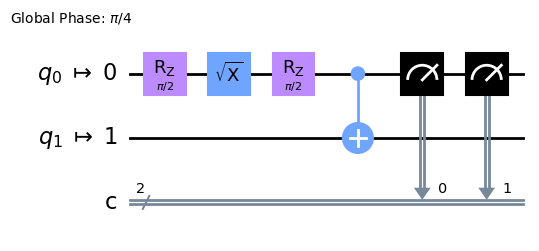

In [5]:
from qiskit import qasm3, QuantumCircuit, transpile

# Creating a bell circuit
qc_bell = QuantumCircuit(2, 2)
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure(0, 0)
qc_bell.measure(0, 1)

qc_bell = transpile(qc_bell, backend)
qc_bell.draw(output="mpl", idle_wires=False)

In [6]:
exporter = qasm3.Exporter(
    includes=[], disable_constants=True, basis_gates=backend.configuration().basis_gates
)

print(qasm3_bell := exporter.dumps(qc_bell))

OPENQASM 3;
bit[2] c;
rz(1.5707963267949) $0;
sx $0;
rz(1.5707963267949) $0;
cx $0, $1;
c[0] = measure $0;
c[1] = measure $0;



In [7]:
qasm3_bell_job = run_qasm3_program(qasm3_bell)

Runtime job id: ceqq6cv5otekiij6rdjg
Job Status: job has successfully run


In [8]:
qasm3_bell_result = qasm3_bell_job.result()
print(f"Preparation results: {qasm3_bell_result.get_counts(0)}")

Preparation results: {'0': 479, '1': 7, '11': 514}


QASM 3 programs may be submitted as strings to the backend using Qiskit Runtime's ``qasm3-runner`` program.

In [9]:
my_first_qasm3_program = """
OPENQASM 3.0;

qubit $0;
bit a0;

x $0;
a0 = measure $0;

"""

In [10]:
job = run_qasm3_program(my_first_qasm3_program)

Runtime job id: ceqq6f3hsot3802d2210
Job Status: job has successfully run


In [11]:
result = job.result()
print(f"Preparation results: {result.get_counts(0)}")

Preparation results: {'0': 25, '1': 975}


## OpenQASM 3 in-depth

Let's understand the language statements supported by OpenQASM 3 and execute them on the hardware if supported. To see what features of OpenQASM 3 are currently supported in hardware, please see the [feature table](./feature-table).

### Variables

Let's learn more about the variable support in OpenQASM 3. Variables are used to assign values within a program. Variables representing any classical type can be initialized on declaration.

To declare a qubit:

```
qubit $0;
qubit $1;
```

Other declaration of classical variables:

```
int[32] a;
bit[3] c = "001";
bool my_bool = false;
```

for an integer variable `a`, a register of three bits width `c`, and a Boolean variable `my_bool`.

### Control flow

OpenQASM 3 also supports looping and branching.

#### If-else statements

The statement `if (bool) <true-body>` branches the program if the Boolean evaluates to true, and may optionally be followed by `else <false-body>`. Both `true-body` and `false-body` can be a single statement terminated by a semicolon, or a program block of several statements `{ stmt1; stmt2; }`.

```
bool target = false;
qubit $0;
h $0;
bit output = measure $0;

// example of branching
if (target == output) {
   // do something
} else {
   // do something else
}
```

In [12]:
if_example = """
OPENQASM 3.0;

bit target = 1;
qubit $0;
x $0;
bit check = measure $0;
if (check) {
   x $0;
}

bit[1] result;
result[0] = measure $0;

"""

In [13]:
job = run_qasm3_program(if_example)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6jne2dgblp3mf2c0
Job Status: job has successfully run
Measurement results: {'0': 10, '10': 978, '100': 1, '110': 11}


#### For loops

The statement `for <type> <name> in <values> <body>` loops over the items in values, assigning each value to the variable name in subsequent iterations of the loop `body.values`.

The value can be a range expression in square brackets of the form `[start : (step :)? stop]`. Note that the range is inclusive, so `stop` is the last value iterated over.

```
int a = 1;

// here step=1
for i in [0 : 4] {
   a = i;
}

// here step=2
for i in [0 : 2 : 4] {
   a = i
}
```

In [14]:
for_loop = """
OPENQASM 3.0;

qubit $0;
for i in [0 : 4] {
   U(1.57079632679, 0.0, 3.14159265359) $0;
}

bit[1] result;
result[0] = measure $0;

"""

# U(1.57079632679, 0.0, 3.14159265359) applies a Hadamard gate

In [15]:
job = run_qasm3_program(for_loop)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6lve2dgblp3mf2f0
Job Status: job has successfully run
Measurement results: {'0': 519, '1': 481}


### Classical compute

OpenQASM 3 supports classical computation on individual bits. These bits may be assigned by the program, or as a result of qubit measurement.

Individual bits are declared with the `bit` keyword, or registers of multiple bits may be declared using `bit[size]` where `size` indicates the number of bits in the register. For example,

```
bit a;
bit b;
bit c;
```

declares three individual bits with variable names `a`, `b`, and `c`, while

```
bit[3] result;
```

declares a three-bit register with the name `result;`.

Bits and bit registers may be assigned by the program
```
bit a = 0;
a = 1;

bit[3] result = "101";
result = "010";
```

or they may store individual qubit measurement results.

In [16]:
measure_register_bits = """\
OPENQASM 3.0;
qubit $0;
qubit $1;
qubit $2;
bit a;
a = measure $0;

bit[3] result;
result[0] = measure $0;
result[1] = measure $1;
result[2] = measure $2;
"""

In [17]:
job = run_qasm3_program(measure_register_bits)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6nrhsot3802d22bg
Job Status: job has successfully run
Measurement results: {'0': 967, '1': 1, '10': 1, '11': 12, '100': 8, '1000': 11}


The current dynamic circuits implementation does not support quantum registers; therefore, storing the result of the measurement of a quantum register 
```
qubit[3] qubits;
bits[3] result;
result = measure qubits;
```
is not yet supported.

Classical computation may be applied to bits and bit registers. The current implementation supports computing bitwise operators applied to bits or bit registers. These include:


```
bit a;
bit b;
bit c;
```

Or:
```
c = a | b;
```
And:
```
c = a & b;
```
Xor:
```
c = a ^ b;
```

These may be included as part of ``if`` statements, and grouped using parentheses:

In [18]:
grouped_bitwise = """\
OPENQASM 3.0;

qubit $0;

bit a = 0;
bit b = 1;
bit c;

if ((a | b)) {
   c = 0;
}

if ((a | b) ^ c) {
   c = 1;
}

bit d;
x $0;
d = measure $0;

"""

In [19]:
job = run_qasm3_program(grouped_bitwise)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6prhsot3802d22eg
Job Status: job has successfully run
Measurement results: {'0': 30, '1000': 970}


Taking the logical ``not`` of a bit is currently supported with the form:

In [20]:
logical_not = """\
OPENQASM 3.0;

qubit $0;

bit a;
bit b;
bit c;

a = !a;

if (a | b) {
  c = 1;
}

bit d;
x $0;
d = measure $0;

"""

In [21]:
job = run_qasm3_program(logical_not)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6s76fpt7053qr8sg
Job Status: job has successfully run
Measurement results: {'0': 21, '1000': 979}


At present time, taking the bit negation `~` is not supported.

Bit registers support conditions on individual bits:

In [22]:
bit_comparison = """\
OPENQASM 3.0;

qubit $0;

bit[3] result;
bit c;

if (result[0]) {
   c = 0;
}

bit d;
x $0;
d = measure $0;
"""

In [23]:
job = run_qasm3_program(bit_comparison)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq6u3hsot3802d22kg
Job Status: job has successfully run
Measurement results: {'0': 35, '10000': 965}


bitwise Boolean expressions:

In [24]:
bitwise_boolean = """\
OPENQASM 3.0;

qubit $0;

bit[3] result1;
bit[3] result2;
bit c;

if ((result1 | result2)) {
   c = 0;
}

if ((result1 & result2)) {
   c = 1;
}

bit d;
x $0;
d = measure $0;
"""

In [25]:
job = run_qasm3_program(bitwise_boolean)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq71oc7aa76lano0n0
Job Status: job has successfully run
Measurement results: {'0': 27, '10000000': 973}


and comparison:

In [26]:
bitwise_comparison = """\
OPENQASM 3.0;

qubit $0;

bit[3] result1 = "010";
bit[3] result2 = "101";
bit c;

if (result1 == result2)  {
   c = 1;
}

if (result1 > result2) {
   c = 1;
}

bit d;
x $0;
d = measure $0;
"""

In [27]:
job = run_qasm3_program(bitwise_comparison)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq73oc7aa76lano0p0
Job Status: job has successfully run
Measurement results: {'0': 12, '10000000': 988}


The usage of bit-string literals is currently only supported when initializing bit registers. Therefore, expressions such as

```
if ((result1 | result2) == "000") {
   c = 0;
}

```
are not yet supported.

### Conditional measurement

Classical computation, Boolean expressions, and conditionals may be combined with qubit measurement to implement conditional measurement. Here the result of qubit measurements may be used to conditionally select additional qubit measurements. 
```
qubit $0
qubit $1
bit r1;
bit r2;

r1 = measure $0;
if (r1 == "1") {
    r2 = measure $1;
}
```

``else`` branches may be used to dynamically select individual qubits at runtime:

In [28]:
conditional_measurement_program = """\
OPENQASM 3.0;

qubit $0;
qubit $1;
qubit $2;

bit r0;
bit r1;
bit r2;

x $0;

r0 = measure $0;
if (r0) {
    r1 = measure $1;
} else {
    r2 = measure $2;
}
"""

In [29]:
job = run_qasm3_program(conditional_measurement_program)
counts = job.result().get_counts()
print(f"Measurement results: {counts}")

Runtime job id: ceqq77rhsot3802d22v0
Job Status: job has successfully run
Measurement results: {'0': 27, '1': 973}


Current system limitations prevent accurate reporting of the conditional measurement results once the program terminates. The result of the measurement is stored and used during the program; however, the measurement results will not be reported to the user unless there are subsequent measurements. If there are subsequent measurements, then the conditional measurement will always be reported as `0` to the user.  We expect to add support for reporting conditional measurement results in 2023. 

---

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table